# Exoplanet Course Hands-on Session: Detecting planets using Radial Velocities
### Author: Florian Philipot and Flavien Kieffer

### This jupyter notebook is a support to the Radial Velocity hands-on proposed during the PSL exoplanet class directed by Anne-Marie Lagrange and Johan Mazoyer.

# Part 1 : Determine the radial velocity of the star with the Cross Correlation Function (CCF)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import astropy
import numpy as np
from numpy import ma
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import pylab as plt
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from dace.spectroscopy import Spectroscopy
from astroquery.simbad import Simbad
from rvmodel import *
import corner
import copy

2021-11-23 14:19:41,053 - WARNING - No .dacerc file found. You are requesting data in public mode. If you need to be connected, please create a .dacerc file in your home directory containing your api key. See README for details.


In [2]:
c = 2.99792e5

#Fonctions that will be needed for the cross correlation


#Converts delta wavelengths to delta velocities using doppler formula
def wav_to_dvel(wav):
    dvel = (wav[1:] - wav[:-1]) / (wav[1:]) * c
    return dvel

### Load the series of spectra

In [3]:
series = []
file_list = sorted(glob('synthetic_spectra/*.csv'))
for f in file_list:
    print(f)
    spec = pd.read_csv(f)
        
    series.append(spec)

synthetic_spectra/5800K+00.csv
synthetic_spectra/5800K+05.csv
synthetic_spectra/5800K+10.csv
synthetic_spectra/5800K+15.csv
synthetic_spectra/5800K+20.csv
synthetic_spectra/5800K-05.csv
synthetic_spectra/5800K-10.csv
synthetic_spectra/5800K-15.csv
synthetic_spectra/5800K-20.csv


Text(0, 0.5, 'Flux [ADU]')

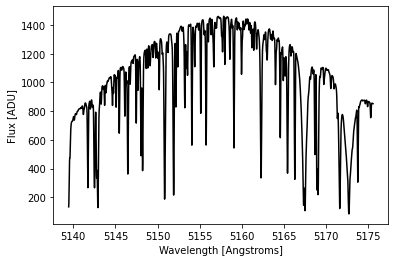

In [4]:
sp = series[0]
plt.plot(sp['wavelength'], sp['flux'], 'k-')
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [ADU]')

(5150.0, 5155.0)

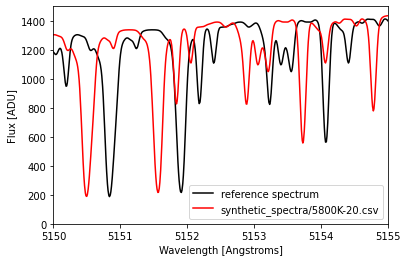

In [14]:
spec_id = 8

spec = series[0]
spec2 = series[spec_id]

pl.plot(spec['wavelength'], spec['flux'], 'k-', label = "reference spectrum")
pl.plot(spec2['wavelength'], spec2['flux'], 'r-', label = file_list[spec_id])

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')
pl.legend()

pl.ylim(0,1500)
pl.xlim(5150, 5155)

### Cross Correlation Fonction

In [6]:
model = series[0] #Reference spectrum
ref_flux = model['flux'].values
ref_wav = model['wavelength'].values

spectrum = series[spec_id] #star spectrum
flux = spectrum['flux'].values
wav = spectrum['wavelength'].values

nwav = wav.size

# Convert target and model spectra to constant log-lambda scale
wav, flux, dvel = rvModel.loglambda(wav, flux,c)

# Perform CCF between two spectra
dv, corr = rvModel.CCF(flux, ref_flux, nwav, dvel,ref_wav,wav)
dlambda, imax = rvModel.dlamb(corr, dv, c)

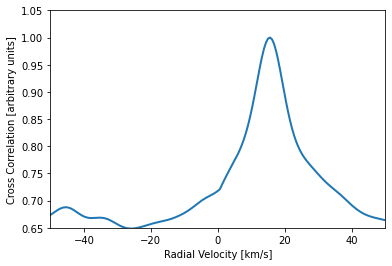

Radial velocity = 15.586742418239343 km/s


(5150.0, 5155.0)

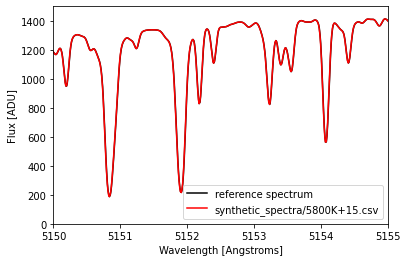

In [7]:
# Plot of the cross correlation
pl.plot(dv, corr, lw=2)
pl.xlim(-50, 50)
pl.ylim(0.65, 1.05)
pl.xlabel('Radial Velocity [km/s]')
pl.ylabel('Cross Correlation [arbitrary units]')
plt.show()
plt.close()

print("Radial velocity =",dv[imax],"km/s")


spec = series[0]
spec2 = series[spec_id]
pl.plot(spec['wavelength'], spec['flux'], 'k-', label = "reference spectrum")
pl.plot(spec2['wavelength']-(dlambda), spec2['flux'], 'r-', label = file_list[spec_id])

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Flux [ADU]')
pl.legend()

pl.ylim(0,1500)
pl.xlim(5150, 5155)

# Part 2 : Radial velocity data processing

In [159]:
# RV data settings : Star selection
target =  'HD 166724'

# Instruments
instruments = [] # By default select all available instruments
inst_sec_acc = {} # Keep default settings for secular correction for each instrument
inst_jitter = {} # Keep default settings for instruments jitter
epoch_rjd = 55500 # Reference epoch

# rjd = Reduced Julian Day : The Julian day is the continuous count of days 
# since the beginning of the Julian period on January 1, 4713 BC

# drift power: add a constant (dpow = 0), a constant + linear drift (dpow = 1), etc.
dpow = 0

# Detrending

indicators = ['rhk'] #Choose the activity indicators (for instance 'rhk', 'fwhm')

#If filter = 1 : no pass filter
#If filter = 2 : low-pass filter
#If filter = 3 : High-pass filter
#If filter = 4 : no activity correction
Filter = 2

indic_filter_timescale_yr = [0.5]  #Time-scale of the filter

if Filter == 1:
    indic_kernel_smoother = [None]#Kernel to filter the indicator chosen
    indic_filter_type = ['full']   #low-pass or high pass filter ('low' or 'high') 
elif Filter == 2:
    indic_kernel_smoother = [tools.gaussian_kernel]#Kernel to filter the indicator chosen
    indic_filter_type = ['low']   #low-pass or high pass filter ('low' or 'high')
elif Filter == 3:
    indic_kernel_smoother = [tools.gaussian_kernel]#Kernel to filter the indicator chosen
    indic_filter_type = ['high']
elif Filter == 4:
    indic_kernel_smoother = [None]#Kernel to filter the indicator chosen
    indic_filter_type = ['']


# Periodogram settings
# The periodogram is computed between periods min and Pmax for nfreq equispaced *frequencies* 
# (not equispaced periods)
Pmin = 1
Pmax = 10000
nfreq = 100000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

# Planet detection settings
fap_max = 1e-3  # Planet search stops if the maximum peak of the periodogram has a false alarm probability (FAP) > fap_max 
max_pla = 10 # The planet search stops when the number of significant signals equals max_pla 

# Fit options
fit_method = 'L-BFGS-B'
fit_options = {
    'maxiter': 1000,
    'maxcor': 50
}
start_fit_jitter_at_step = 0
fit_ecc = True

# MCMC options
nsamples = 100000

### Data download

In [160]:
# Create the dictionary that will contain the data to analyse
rv_data = {} 

# Download data from DACE database (https://dace.unige.ch/radialVelocities)
data_from_Dace = Spectroscopy.get_timeseries(target, sorted_by_instrument=True)

# Organize downloaded data
nt,rv_data,Baseline,ninst,default_inst_jitter,instruments = rvModel.organize_data(instruments,rv_data,data_from_Dace,indicators)

print('Number of points :', nt)
print('Baseline :', round(Baseline, 1) , 'days')

Number of points : 55
Baseline : 2676.7 days


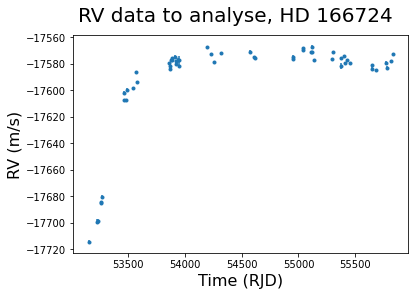

In [161]:
plt.figure()
for kinst in range(ninst):
    plt.errorbar(
        rv_data['rjd'][rv_data['inst_id']==kinst],
        rv_data['rv'][rv_data['inst_id']==kinst],
        yerr= rv_data['rv_err'][rv_data['inst_id']==kinst],# rv_err[rv_data['inst_id']==kinst],
        fmt='.', rasterized=True)
plt.xlabel('Time (RJD)',fontsize = 16)
plt.ylabel('RV (m/s)',fontsize = 16)
plt.suptitle('RV data to analyse, {}'.format(target),fontsize = 20)
plt.show()
plt.close()

### Correction of star activity

Plot activity indicator: rhk_low


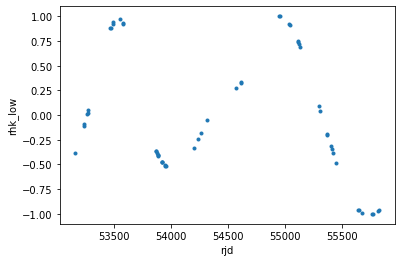

Parameter                        Value     Error       
lin.offset_inst_0           -17590.500  ±  0.216       
lin.rhk_low                     -1.618  ±  0.339       



In [162]:
# Add stellar jitter parameter
rv_err,rv_model,rhk_model = rvModel.jitter(instruments,default_inst_jitter,rv_data,epoch_rjd,inst_jitter)

# Add linear parameters
rv_model,rhk_model,indic_name,tmp = rvModel.lin_param(ninst,rv_data,dpow,rv_model,rhk_model,indic_filter_timescale_yr,indic_kernel_smoother,indic_filter_type,Filter)
    
print('Plot activity indicator: {}'.format(indic_name))
plt.figure()
for kinst in range(ninst):
    plt.plot(rv_data['rjd'][rv_data['inst_id']==kinst],
             tmp[rv_data['inst_id']==kinst],
                '.', rasterized=True)
plt.xlabel('rjd')
plt.ylabel(indic_name)
plt.show()
plt.close()    


rv_model.fit(method=fit_method,options=fit_options)
rhk_model.fit(method=fit_method,options=fit_options)

#select which noise parameters are fitted by adding them to the variable rv_model.fitparams
jitter_params = ['cov.var_jitter_inst.{}'.format(kinst) for kinst in range(ninst)]
if start_fit_jitter_at_step == 0:
    #rv_model.fitparams += jitter_params # We add the jitters, but leave the exponential decay fixed. 
    rv_model.fit(method=fit_method,options=fit_options)
    rv_model.show_params()
rv_model_init=copy.copy(rv_model)

### RV analysis

Plot RV data:


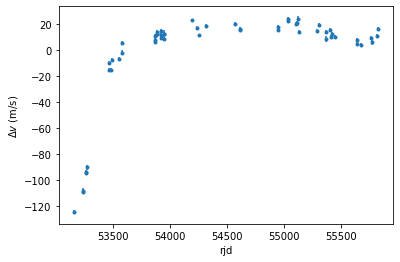

Periodogram of RV data:


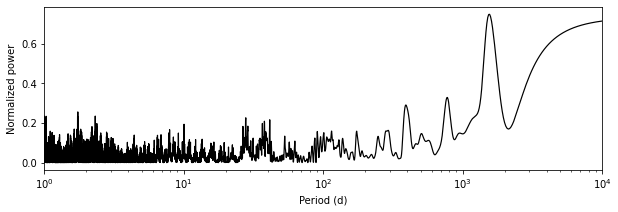

Periodogramme of rhk:


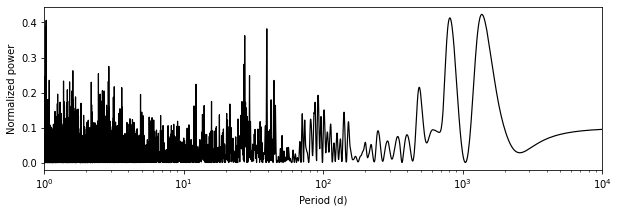

Highest periodogram peak:
P=1562.6186625413122 d, power=0.7478684806028639, FAP=1.4700615759470077e-11

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_0            -17602.92  ±  1.93        
lin.rhk_low                     18.235  ±  0.453       
pla.0.P                        1496.41  ±  1.79        
pla.0.M0                        3.5036  ±  0.0152      
pla.0.K                            609  ±  338         
pla.0.e                         0.9500  ±  0.0253      
pla.0.w                         2.9081  ±  0.0650      

loglikelihood = -847.7003020661836

Plot residuals:


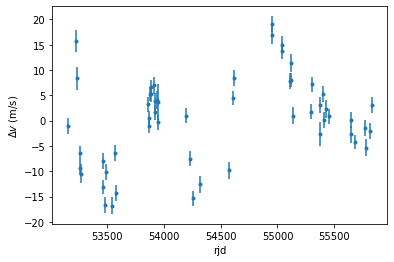

Periodogram of residuals:


In [ ]:
rv_model=rv_model_init
for _ in range(max_pla):
    # Plot residuals
    if _ == 0 :
        print('Plot RV data:')
    else:
        print('Plot residuals:')
    res = rv_model.residuals()
    rv_err = np.sqrt(rv_model.cov.A)
    plt.figure()
    for kinst in range(ninst):
        plt.errorbar(
            rv_data['rjd'][rv_data['inst_id']==kinst],
            res[rv_data['inst_id']==kinst],
            yerr=rv_err[rv_data['inst_id']==kinst],
            fmt='.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()
    
    # Compute periodogram
    if _ == 0 :
        print('Periodogram of RV data:')
    else:
        print('Periodogram of residuals:')
        
    nu, power = rv_model.periodogram(nu0, dnu, nfreq)
    nu1, power1 = rhk_model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu
    P1 = 2 * np.pi / nu1
    # Compute FAP
    kmax = np.argmax(power)
    faplvl = rv_model.fap(power[kmax], nu.max())
    
    plt.figure(figsize=(10, 3))
    plt.plot(P, power, 'k', lw=1.2, rasterized=True)
    plt.xlim(Pmin, Pmax)
    #plt.ylim(power.min(), 1.1 * power.max())
    plt.xscale('log')
    plt.xlabel('Period (d)')
    plt.ylabel('Normalized power')
    plt.show()
    plt.close()
    
    if _ == 0 :
        print('Periodogramme of rhk:')
        plt.figure(figsize=(10, 3))
        plt.plot(P1, power1, 'k', lw=1.2, rasterized=True)
        plt.xlim(Pmin, Pmax)
        #plt.ylim(power.min(), 1.1 * power.max())
        plt.xscale('log')
        plt.xlabel('Period (d)')
        plt.ylabel('Normalized power')
        plt.show()
        plt.close()
    
    # Show results
    print('Highest periodogram peak:')
    print('P={} d, power={}, FAP={}\n'.format(P[kmax], power[kmax], faplvl))
    if faplvl > fap_max:
        print('Stopping here (non-significant detection)')
        break    
    print('Fit all parameters:')
    # Add new planet
    rv_model.smartaddpla(P[kmax])
    
    rv_model.changeparpla(rv_model.planame[-1], params=['P', 'M0', 'K', 'e', 'w'])

    if not fit_ecc: #If the orbits are assumed circular
        rv_model.set_params(np.zeros(2), rv_model.fitparams[-2:])
        rv_model.fitparams = rv_model.fitparams[:-2]
    # Add jitter to fitparams if needed
    if rv_model.npla == start_fit_jitter_at_step:
        rv_model.fit(method=fit_method, options=fit_options)
        rv_model.fitparams += jitter_params
    # Global fit of the model
    rv_model.fit(method=fit_method, options=fit_options)
    rv_model.show_params()
    print('loglikelihood = {}\n'.format(rv_model.loglike()))

### Phase folding

In [ ]:
res = rv_model.residuals()
rv_err = np.sqrt(rv_model.cov.A)

for kpla, pla in enumerate(rv_model.kep):
    params = pla.get_param()
    rv_model.changeparpla(rv_model.planame[kpla], params=['P', 'M0', 'K', 'e', 'w']) 
    # M0: mean motion at t = epoch_rjd
    # https://en.wikipedia.org/wiki/Mean_anomaly
    n = 2*np.pi/(rv_model.get_params('pla.{}.P'.format(kpla)))
    M0 = rv_model.get_params('pla.{}.M0'.format(kpla))
    M = (M0 + n*rv_model.t)*180/np.pi % 360
    Mmod = np.linspace(0,360,1000)
    tmod = (Mmod*np.pi/180-M0)/n
    print('Planet {} ({:.3f} d)'.format(kpla, 2*np.pi/n))
    plt.figure()
    plt.xlim(0,360)
    plt.xticks([0,90,180,270,360])
    plt.plot(Mmod, pla.rv(tmod), 'k', lw=3, rasterized=True)
    for kinst in range(ninst):
        plt.errorbar(
            M[rv_data['inst_id']==kinst],
            (res+pla.rv(rv_model.t))[rv_data['inst_id']==kinst],
            yerr=rv_err[rv_data['inst_id']==kinst],
            fmt='.', rasterized=True)
    plt.xlabel('Mean anomaly (deg)')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()

### Launch MCMC

In [ ]:
samples, diagnos = rv_model.sample(nsamples=nsamples, logprior=lambda fitparams, x:0)

### Corner plot

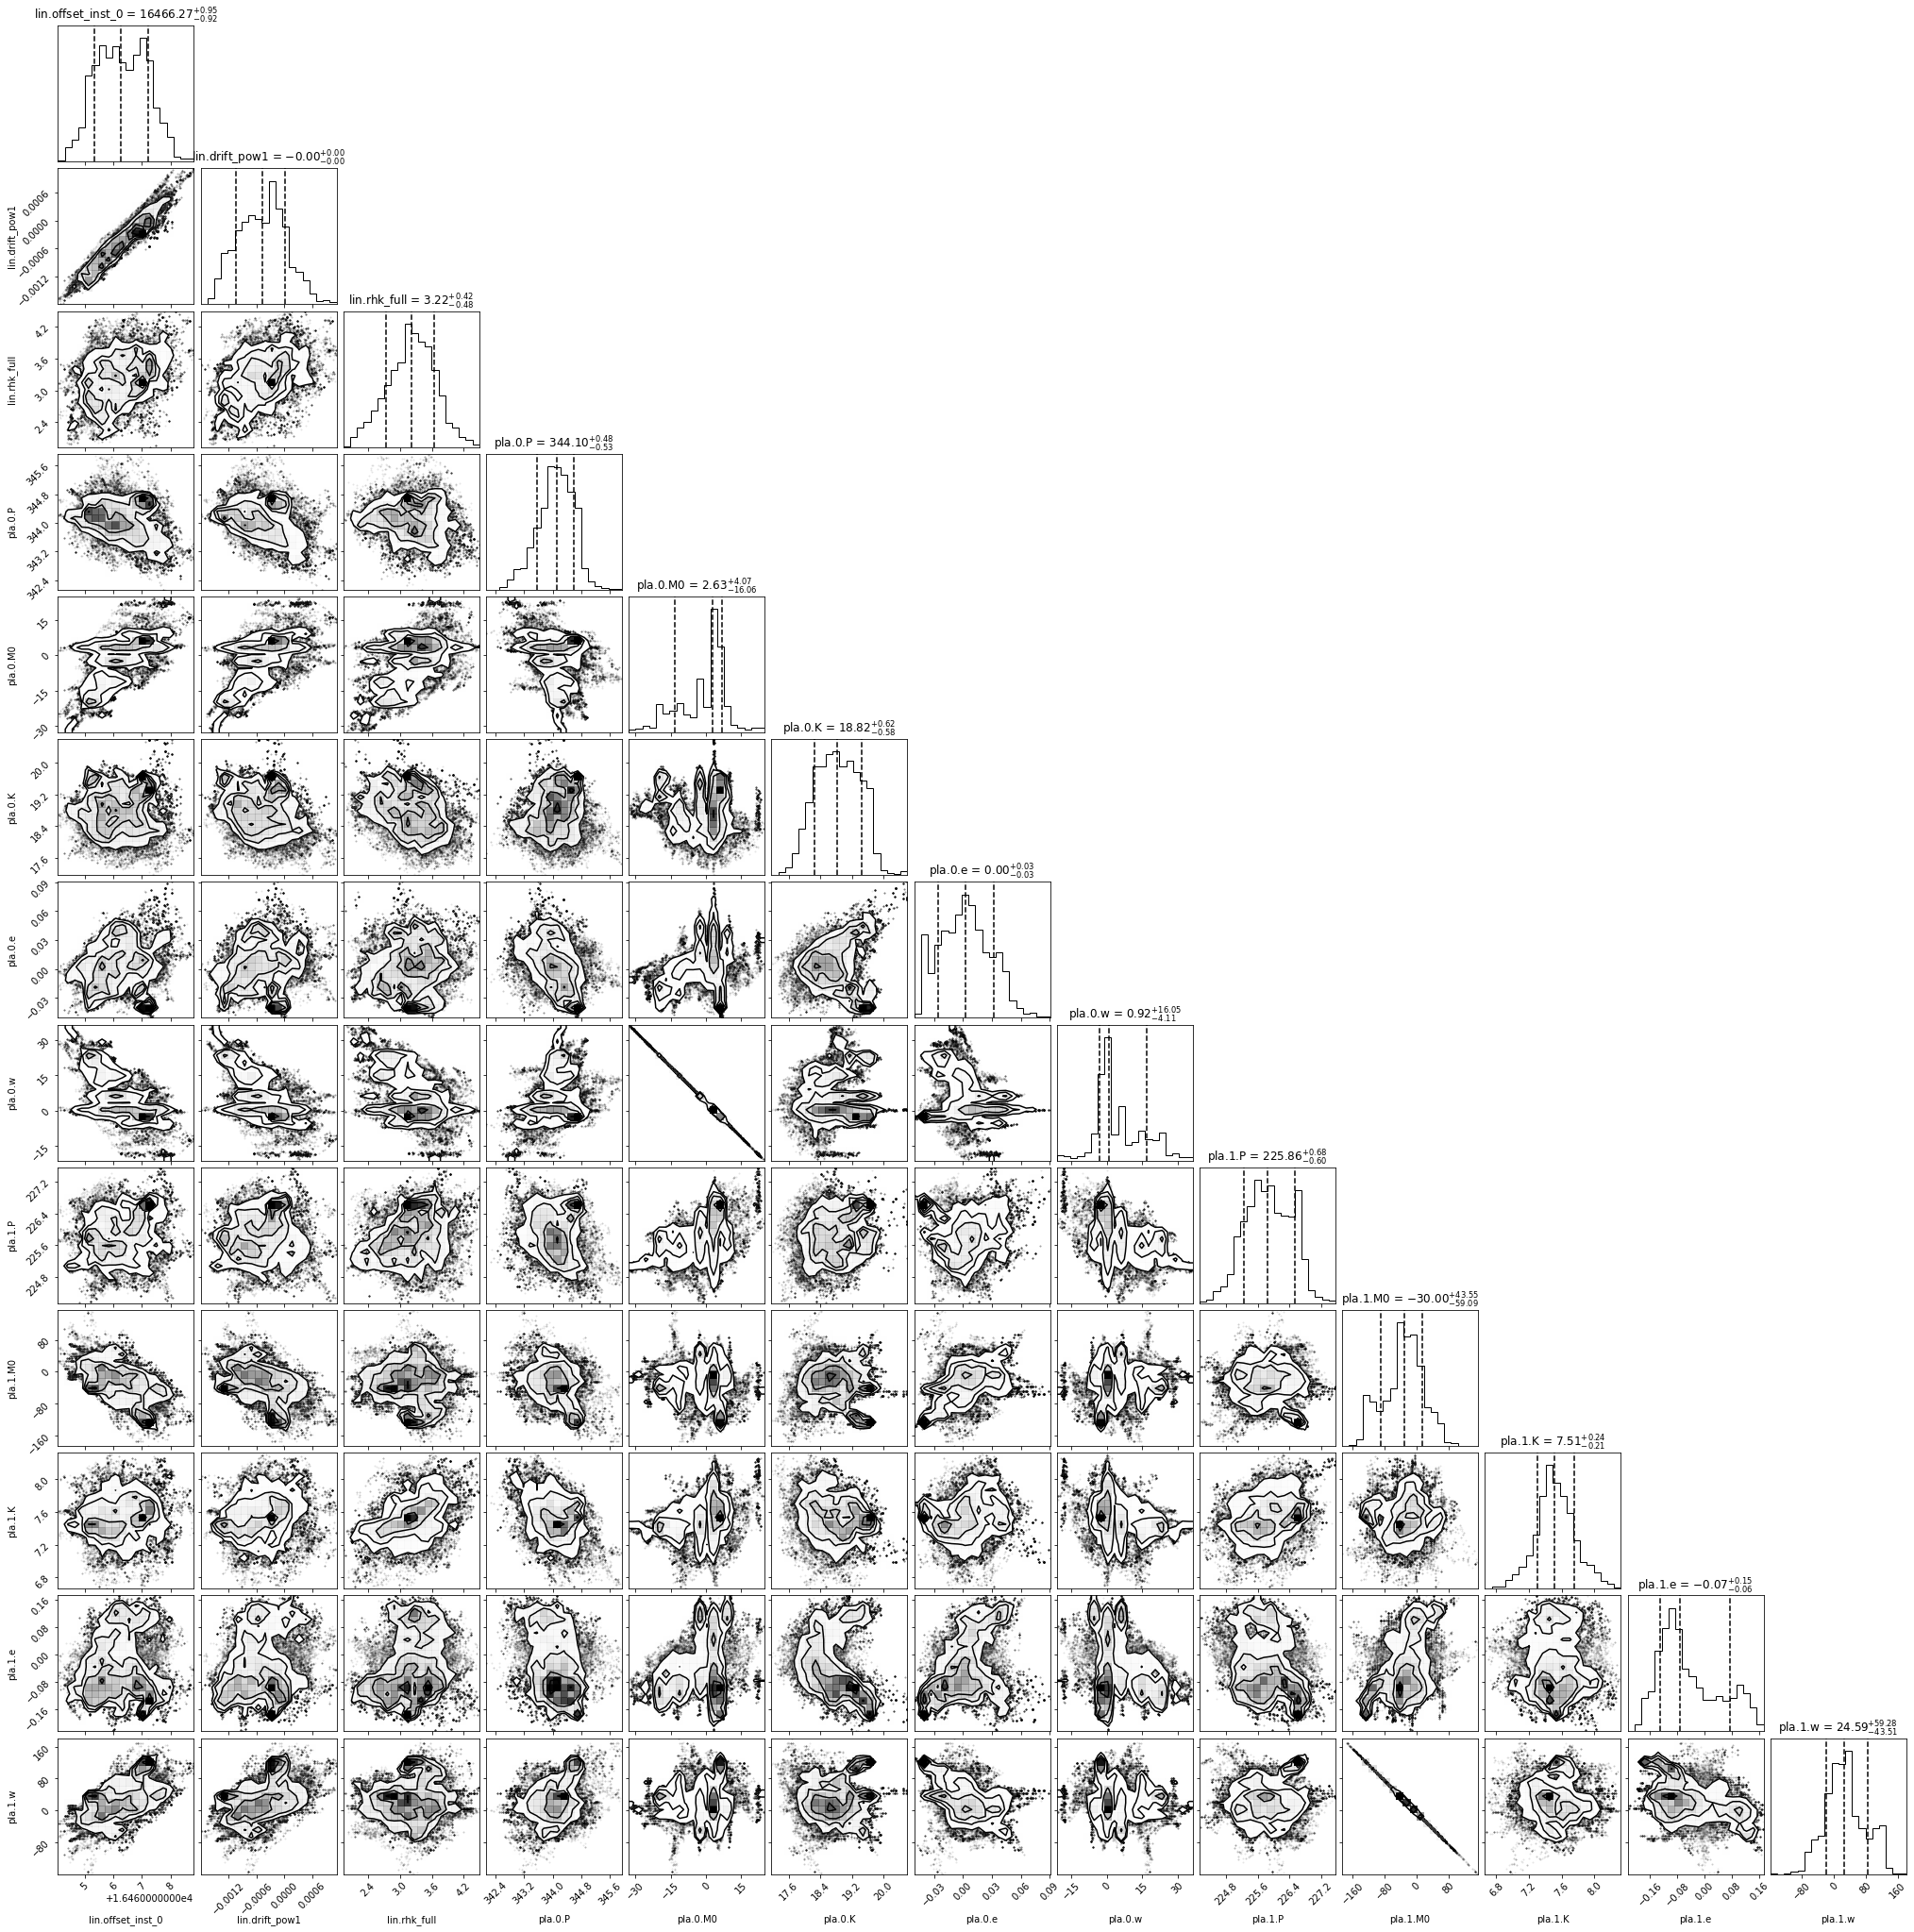

In [135]:
corner.corner(
    samples[nsamples//4:],
    labels=rv_model.fitparams,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True)
plt.show()
plt.close()

## Acknowledgements